<a href="https://colab.research.google.com/github/joseortegalabra/Proyect-GANs/blob/master/dcgan_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imageio

In [ ]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import imageio

import time
from IPython import display

In [ ]:
from skimage import io
import cv2

In [ ]:
#cargar datos Mnist
(X_train, y_test), (X_test, y_test) = tf.keras.datasets.mnist.load_data()    #usar mnist data set


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#60000 imagenes de 28x28    
X_train.shape   

(60000, 28, 28)

In [ ]:
#redimencionar las imagenes a un array 60000, 28,28,1   1 canal
data = np.expand_dims(X_train, axis = 3)
data.shape

(60000, 28, 28, 1)

In [ ]:
#normalizar la imagen

#normalizar la imagen entre -1 y 1
data = (data - 127.5) / 127.5    

#normalizar la imagen entre 0 y 1
#data = data /255.0

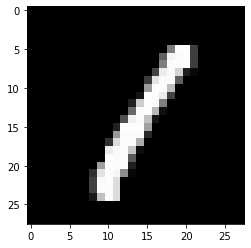

In [ ]:
#EJEMPLO DE GRAFICAR LA IMAGEN X
X = 3
plt.imshow(data[X, :,:, 0], cmap='gray')

In [ ]:
#crear data set de tensorflow con la cantidad de elementos reordenados de forma random(buffer) y el tamaño del batch 
#reordeno los datos de forma random y luego extraigo un batch del tamaño indicado
buffer_size = 60000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size).batch(batch_size)

# Model

### Generator


In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  
  #first layers fully conected
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,) )       )      #salida es una capa de tamaño 7x7x256 neuronas y la entrada es una capa de 100 neuronas
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #segunda capa reordeno las neuronas de la capa fully contected para que tenga formato de imagen - lo contrario a un flattten
  model.add(layers.Reshape((7, 7, 256)))         
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  #tercera capa, una capa de deconvolusión con salida 128 canales, filtro de (5,5) con stride de 1
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #cuarta capa deconvlusión con 64 canales (filtros)
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #quinta capa deconvolusión con 1 filtro y que me genera una imagen de 28x28x1 que es el tamaño original
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

In [ ]:
#crear el modelo generador
generator = make_generator_model()

#crea el input de la red neuronal que es una imagen de ruido
noise = tf.random.normal([1, 100])     #le paso un tensor de tensorflow de 100 elementos?

#hacer pasar el ruido por la red neuronal generator y evaluar solamente, sin entrenar la red como este ruido
generated_image = generator(noise, training=False)

In [ ]:
generated_image.shape   #SE OBTIENE 1 IMAGEN DE 28X28X1

TensorShape([1, 28, 28, 1])

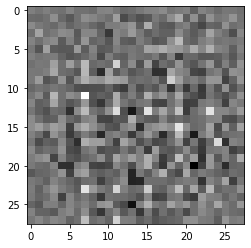

In [ ]:
#mostrar la imagen generada
plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

### Discriminador

In [ ]:
def make_discriminator_model():
    #crear el modelo sequencial
    model = tf.keras.Sequential()
    
    #primera capa conv2d   64 canales, filter = (5x5), stride =2 , tamaño de entrada 28x28x1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #segunda capa conv2d   128 canales, filtro = (5x5), stride = 2
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #tercera capa flatten y fully connected de salida una neurona  --->>>>VALOR POSITIVO PARA UNA IMAGEN REAL Y NEGATIVO PARA UNA IMAGEN FICTICIA
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
#crear el modelo discriminador
discriminator = make_discriminator_model()

In [ ]:
#EJEMPLO: probar en el discriminador la imagen generada
decision = discriminator(generated_image)

#valor en el discriminador que no esta entrenado y está con valores random
print (decision)     

tf.Tensor([[0.00373203]], shape=(1, 1), dtype=float32)


### definir loss y optimizador

In [ ]:
#loss para un modelo binario si o no
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)     #cross_entropy(imagen_real, imagen_predicha)

#### Definir loss para discriminador
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):     #salida por el discriminador de la imagen real, salida por el discriminador de la imagen ficticia
    
    #perdida de la imagen real en el discriminador = (vector de unos, salida por el discriminador de la imagen real)     
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)    
    
    #perdida de la imagen ficticia en el discriminador = (vector de zeros, salida por el discriminador de la imagen ficticia)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    #perdida total del discriminador = perdida en el discriminador de la imagen real y la imagen predicha
    total_loss = real_loss + fake_loss
    return total_loss

#PASAR POR EL DISCRIMINADOR ME EVALUA UNA IMAGEN Y ME DA UN VALOR DE 1 SI CREE QUE ES UNA IMAGEN REAL Y UN VALOR DE 0 SI CREE ES UNA FICTICIA,
#si discrimina bien para la imagen ficticia le va da un valor 0 y la loss es baja, si discrimina mal para la loss le puede dar valor 1 y por lo tanto
#la loss es alta 

#### Definir loss para generador
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
#si el generador funciona bien el discriminador tomara la imagen ficticia como real y le dara valor 1
def generator_loss(fake_output):      #por el generador solo pasa la imagen ficticia 
    return cross_entropy(tf.ones_like(fake_output), fake_output)     #vector de 1, salida del driscriminador de la imagen ficticia

#POR EL DISCRIMINADOR QUIERO QUE ME EVALUE MAL LA IMAGEN FICTICIA Y ME DEVUELVA VALOR 1, esto hace que la loss del generador sea muy baja 
#porque está haciendo su trabajo bien y en cambio la loss del discriminador es muy alta porque esta haciendo su trabajo mal

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Crear un checkpoint porque es un modelo que quiere horas de entrenamiento

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Crear loop de entrenamiento

In [ ]:
#hiperparámetros
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

#semilla con el ruido inicial que se utiliza para generar las imagenes deseadas
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])       #batch size esta arriba no lo pase como argumento de la funcion

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Entrenar el modelo


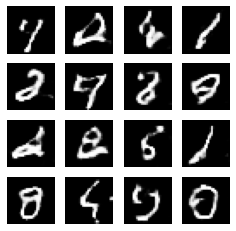

In [ ]:
train(train_dataset, epochs)

In [ ]:
print(stop)

NameError: ignored

In [ ]:
#Restore the latest checkpoint.

#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#### Crear un GIF con los resultados


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

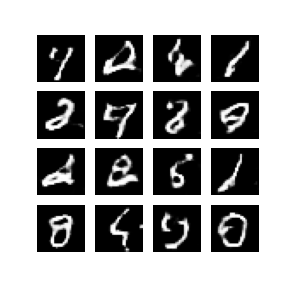

In [ ]:
display_image(epochs)

Use imageio to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>